Test part of the code to debug collecting data and preprocessing

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import shutil

Load Original image

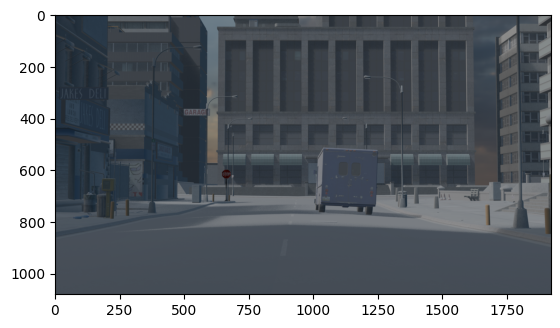

In [64]:
image_base = cv2.imread("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\images\\image_001_0001.png")
image_base = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)
plt.imshow(image_base)

Load image with turned off environment

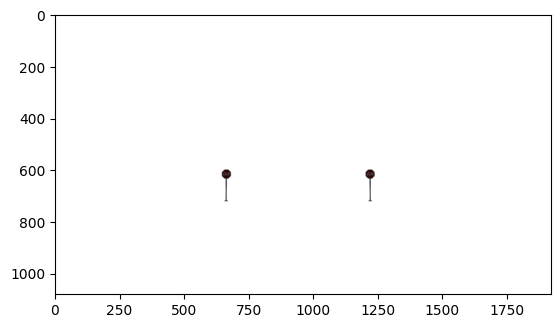

In [65]:
image_label = cv2.imread("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\labels\\image_001_0001_label.png", cv2.IMREAD_UNCHANGED)
image_label = cv2.cvtColor(image_label, cv2.COLOR_BGRA2RGBA)
plt.imshow(image_label)

Extract contours of stop signs

In [67]:
# Извлечение альфа-канала
alpha_channel = image_label[:, :, 3]
# Бинаризация маски
_, mask = cv2.threshold(alpha_channel, 1, 255, cv2.THRESH_BINARY)

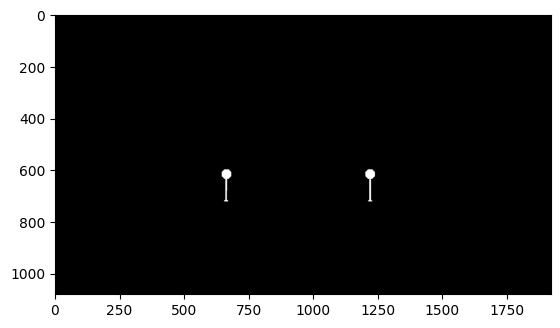

In [71]:
plt.imshow(mask, cmap='gray')

In [72]:
# Поиск контуров
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Euclidean Distance: 0.8010047138121289


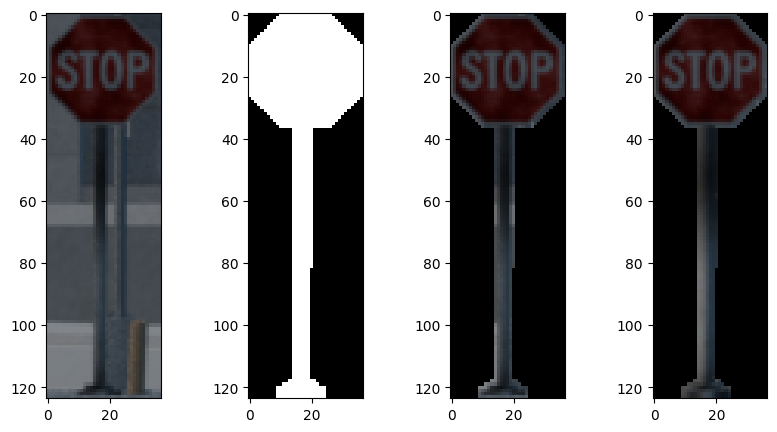

In [115]:
x, y, w, h = cv2.boundingRect(contours[1])
body = image_base[y:y+h,x:x+w]
body_label = image_label[y:y+h,x:x+w]
body_mask = mask[y:y+h,x:x+w]

masked_image = cv2.bitwise_and(body[:, :, :3], body[:, :, :3], mask=body_mask)
masked_image_label = cv2.bitwise_and(body_label[:, :, :3], body_label[:, :, :3], mask=body_mask)
mean_value_image = cv2.mean(masked_image[:, :, :3], mask=body_mask)
mean_value_label = cv2.mean(masked_image_label[:, :, :3], mask=body_mask)


# Method 1: Calculate Absolute Difference
# Method 2: Calculate Euclidean Distance
distance = np.linalg.norm(np.array(mean_value_image[:3]) - np.array(mean_value_label[:3]))
print(f"Euclidean Distance: {distance}")

fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(body)
ax[1].imshow(body_mask, cmap='gray')
ax[2].imshow(masked_image, cmap='gray')
ax[3].imshow(masked_image_label, cmap='gray')


(60.964444444444446, 69.2, 85.11833333333334, 0.0)
(51.21699716713881, 40.31841359773371, 44.10084985835694, 0.0)


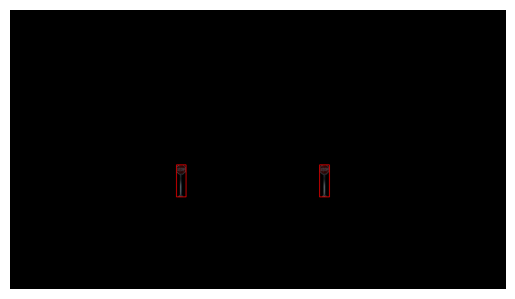

In [93]:
# Рисуем bounding box
output_image = image_label[:, :, :3].copy()  # Убираем альфа-канал

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    body = image_base[y:y+h,x:x+w]
    body_mask = mask[y:y+h,x:x+w]
    # Применение маски
    masked_image = cv2.bitwise_and(body[:, :, :3], body[:, :, :3], mask=body_mask)
    # Среднее значение пикселей в маске
    mean_value = cv2.mean(body[:, :, :3], mask=body_mask)
    print(mean_value)


    cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Отображение результата
plt.imshow(output_image)
plt.axis('off')
plt.show()

Загрузим данные о изображениях и лейблах к ним

In [128]:
images_path = sorted(os.listdir("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\images"))
labels_path = sorted(os.listdir("C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\labels"))

Создание словаря с данными об изображении и аннотации

In [129]:
data = {}
data["info"] = {'year': '2024', 'version': '1', 'description': 'Stop Sign Dataset', 'contributor': 'Kirill Starodubov', 'url': None, 'date_created': '2024-12-11'}
data["lincenses"] = [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}]
data["images"]=[]
data["annotations"]=[]
data["categories"]=[{'id': 1, 'name': 'stop-sign'}]
data

{'info': {'year': '2024',
  'version': '1',
  'description': 'Stop Sign Dataset',
  'contributor': 'Kirill Starodubov',
  'url': None,
  'date_created': '2024-12-11'},
 'lincenses': [{'id': 1,
   'url': 'https://creativecommons.org/licenses/by/4.0/',
   'name': 'CC BY 4.0'}],
 'images': [],
 'annotations': [],
 'categories': [{'id': 1, 'name': 'stop-sign'}]}

In [130]:
counter = 0
for i in range(len(images_path)):
    # Определение пути к файлам
    image_path = "C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\images\\" + images_path[i]
    label_path = "C:\\Users\\SKG\\GitHub\\3D_ComputerVision\\blender_augmentation\\models\\data\\labels\\" + labels_path[i]
    
    # Открытие файлов с cv2
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    label = cv2.cvtColor(label, cv2.COLOR_BGRA2RGBA)

    data["images"].append({"id": i, 'license': 1, "file_name": images_path[i], "height": image.shape[0], "width": image.shape[1], 'date_captured': None})
    
    # Извлечение альфа-канала
    alpha_channel = label[:, :, 3]
    # Бинаризация маски
    _, mask = cv2.threshold(alpha_channel, 1, 255, cv2.THRESH_BINARY)

    # Поиск контуров
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Рисуем bounding box
    output_image = image[:, :, :3].copy()  # Убираем альфа-канал

    for j, contour in enumerate(contours):
        # ---------------------------------------------------------------
        x, y, w, h = cv2.boundingRect(contour)
        body = image[y:y+h,x:x+w]
        body_label = label[y:y+h,x:x+w]
        body_mask = mask[y:y+h,x:x+w]

        masked_image = cv2.bitwise_and(body[:, :, :3], body[:, :, :3], mask=body_mask)
        masked_image_label = cv2.bitwise_and(body_label[:, :, :3], body_label[:, :, :3], mask=body_mask)
        mean_value_image = cv2.mean(masked_image[:, :, :3], mask=body_mask)
        mean_value_label = cv2.mean(masked_image_label[:, :, :3], mask=body_mask)

        distance = np.linalg.norm(np.array(mean_value_image[:3]) - np.array(mean_value_label[:3]))
        
        if distance < 30:
            data["annotations"].append({"id": counter, "image_id": i, "category_id": 1, "bbox": [x, y, w, h], "area": w * h, "segmentation": [], "iscrowd": 0})
            counter += 1
               
        # ---------------------------------------------------------------



In [132]:
# Сохранение в файл
with open("./models/annotations.json", "w") as f:
    json.dump(data, f, indent=4)

Test

In [133]:
from collections import defaultdict
# Grouping annotations by image_id
annotations_by_image = defaultdict(list)

In [134]:
# Fill the dictionary
for annotation in data["annotations"]:
    annotations_by_image[annotation['image_id']].append(annotation)

In [136]:
image_id_to_find = 1
found_annotations = annotations_by_image[image_id_to_find]
found_annotations

[{'id': 2,
  'image_id': 1,
  'category_id': 1,
  'bbox': [1107, 604, 35, 115],
  'area': 4025,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 1,
  'category_id': 1,
  'bbox': [597, 604, 35, 115],
  'area': 4025,
  'segmentation': [],
  'iscrowd': 0}]

Проверка работоспособности аннотации

In [162]:
# Загрузка в файл
with open("models/annotations.json") as file:
    data = json.load(file)

(-0.5, 1919.5, 1079.5, -0.5)

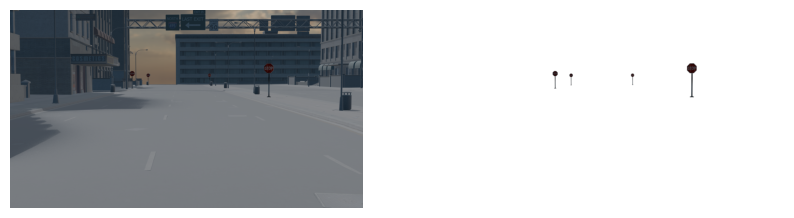

In [163]:
im_path = data["images"][93]["file_name"]
image_path = "./models/data/images/" + im_path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.axis("off")
# plt.imshow(image)

lab_path = "./models/data/labels/" + im_path.split(".")[0] + "_label.png"
image_label = cv2.imread(lab_path, cv2.IMREAD_UNCHANGED)
image_label = cv2.cvtColor(image_label, cv2.COLOR_BGRA2RGBA)
# plt.imshow(image_label)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(image);
ax[0].axis("off")
ax[1].imshow(image_label);
ax[1].axis("off")


In [176]:
image_id_to_find = 93
found_annotations = annotations_by_image[image_id_to_find]
found_annotations

[{'id': 165,
  'image_id': 93,
  'category_id': 1,
  'bbox': [741, 350, 20, 65],
  'area': 1300,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 166,
  'image_id': 93,
  'category_id': 1,
  'bbox': [1076, 349, 19, 64],
  'area': 1216,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 167,
  'image_id': 93,
  'category_id': 1,
  'bbox': [650, 336, 29, 96],
  'area': 2784,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 168,
  'image_id': 93,
  'category_id': 1,
  'bbox': [1381, 294, 55, 186],
  'area': 10230,
  'segmentation': [],
  'iscrowd': 0}]

In [165]:
output_image = image.copy()

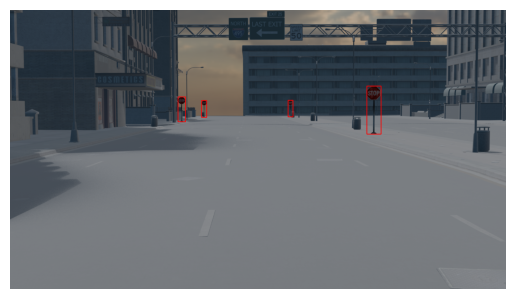

In [166]:
for e in found_annotations:
    x,y,w,h = e["bbox"]
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.imshow(output_image)
plt.axis("off")
plt.show()



Разобьём датасет на 3 части: train, val, test

In [204]:
train_annotations = {}
train_annotations["info"] = {'year': '2024', 'version': '1', 'description': 'Stop Sign Dataset', 'contributor': 'Kirill Starodubov', 'url': None, 'date_created': '2024-12-11'}
train_annotations["lincenses"] = [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}]
train_annotations["images"]=[]
train_annotations["annotations"]=[]
train_annotations["categories"]=[{'id': 1, 'name': 'stop_sign'}]

valid_annotations = {}
valid_annotations["info"] = {'year': '2024', 'version': '1', 'description': 'Stop Sign Dataset', 'contributor': 'Kirill Starodubov', 'url': None, 'date_created': '2024-12-11'}
valid_annotations["lincenses"] = [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}]
valid_annotations["images"]=[]
valid_annotations["annotations"]=[]
valid_annotations["categories"]=[{'id': 1, 'name': 'stop_sign'}]

test_annotations = {}
test_annotations["info"] = {'year': '2024', 'version': '1', 'description': 'Stop Sign Dataset', 'contributor': 'Kirill Starodubov', 'url': None, 'date_created': '2024-12-11'}
test_annotations["lincenses"] = [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}]
test_annotations["images"]=[]
test_annotations["annotations"]=[]
test_annotations["categories"]=[{'id': 1, 'name': 'stop_sign'}]


In [200]:
images_path = sorted(os.listdir("./models/data/images"))
labels_path = sorted(os.listdir("./models/data/labels"))

In [205]:
# Shuffle and split
indices = np.arange(len(images_path))
np.random.shuffle(indices)

train_size = int(0.7 * len(indices))
valid_size = int(0.2 * len(indices))

train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size + valid_size]
test_indices = indices[train_size + valid_size:]

indices_set = [train_indices, valid_indices, test_indices]
# Results
print(f"Train: {len(train_indices)}, Val: {len(valid_indices)}, Test: {len(test_indices)}")


Train: 84, Val: 24, Test: 12


In [206]:
for idx in train_indices:
    train_annotations["images"].append(data["images"][idx])
    found_annotations = annotations_by_image[idx]
    shutil.copy(f"./models/data/images/{data['images'][idx]['file_name']}", f"./models/data/dataset/train/{data['images'][idx]['file_name']}")
    for d in found_annotations:
        train_annotations["annotations"].append(d)
        
with open("./models/data/dataset/train/annotations_train.json", "w") as f:
    json.dump(train_annotations, f, indent=4)
    
for idx in valid_indices:
    valid_annotations["images"].append(data["images"][idx])
    found_annotations = annotations_by_image[idx]
    shutil.copy(f"./models/data/images/{data['images'][idx]['file_name']}", f"./models/data/dataset/valid/{data['images'][idx]['file_name']}")
    for d in found_annotations:
        valid_annotations["annotations"].append(d)
    
with open("./models/data/dataset/valid/annotations_valid.json", "w") as f:
    json.dump(valid_annotations, f, indent=4)
    
for idx in test_indices:
    test_annotations["images"].append(data["images"][idx])
    shutil.copy(f"./models/data/images/{data['images'][idx]['file_name']}", f"./models/data/dataset/test/{data['images'][idx]['file_name']}")
    found_annotations = annotations_by_image[idx]
    for d in found_annotations:
        test_annotations["annotations"].append(d)

with open("./models/data/dataset/test/annotations_test.json", "w") as f:
    json.dump(test_annotations, f, indent=4)        

In [208]:
test_annotations["images"][0]

{'id': 29,
 'license': 1,
 'file_name': 'image_001_0029.png',
 'height': 1080,
 'width': 1920,
 'date_captured': None}

In [209]:
# Загрузка в файл
with open("test.json") as file:
    test_data = json.load(file)

In [210]:
test_data["images"][0]

{'id': 0,
 'license': 1,
 'file_name': 'PXL_20220525_093922556_jpg.rf.c611a9b4e68a58c4ad590da1b988b594.jpg',
 'height': 416,
 'width': 416,
 'date_captured': '2023-08-22T22:41:32+00:00'}